# Algoritmo de visión computacional

# **Imágenes de perros y gatos para clasificación**
Este conjunto de datos abarca una colección de imágenes seleccionadas específicamente con el fin de clasificar entre perros y gatos.

In [1]:
import pandas as pd
data1 = pd.read_csv("datos_vision_c\cat_dog.csv")

data1.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [2]:
len(data1)

25000

In [3]:
print("isnull: \n",data1.isnull().sum())

isnull: 
 image     0
labels    0
dtype: int64


In [4]:
print(data1.duplicated().sum())

0


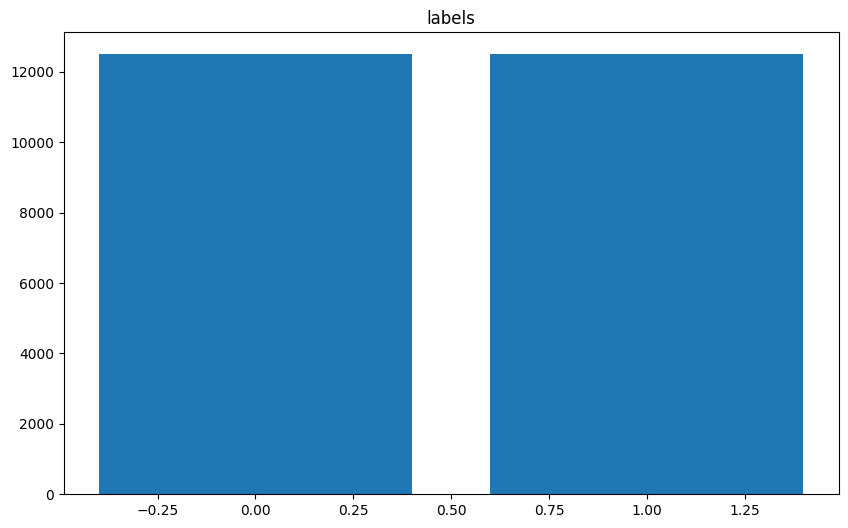

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(data1['labels'].value_counts().index, data1['labels'].value_counts())
plt.title("labels")
plt.show()

In [6]:
#construir la lista de rutas de archivos y etiquetas correspondientes para cada imagen. 
import csv
import os

def cargar_datos_desde_csv(csv_file, root_dir):
    # Lista para almacenar las rutas de las imágenes y sus etiquetas
    datos = []
    
    # Abrir el archivo CSV
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Saltar la primera fila (encabezado)
        
        # Iterar sobre las filas del archivo CSV
        for row in reader:
            filename, label = row
            label = int(label)  # Convertir la etiqueta a entero
            
            # Construir la ruta completa de la imagen
            img_path = os.path.join(root_dir, filename)
            
            # Agregar la tupla (ruta de la imagen, etiqueta) a la lista de datos
            datos.append((img_path, label))
    
    return datos

# Ruta del archivo CSV y directorio que contiene las imágenes directamente
csv_file = 'datos_vision_c\cat_dog.csv'
root_dir = 'datos_vision_c\cat_dog'

# Cargar los datos desde el archivo CSV
datos = cargar_datos_desde_csv(csv_file, root_dir)

# Verificar los primeros elementos de la lista de datos
print(datos[:3])

[('datos_vision_c\\cat_dog\\dog.11289.jpg', 1), ('datos_vision_c\\cat_dog\\cat.10836.jpg', 0), ('datos_vision_c\\cat_dog\\cat.7970.jpg', 0)]


In [7]:
import dask.dataframe as dd
from dask.distributed import Client

# Configuración del cliente Dask
client = Client(n_workers=4, threads_per_worker=2,memory_limit='2GB')
#print(client)

In [8]:
import pandas as pd
# Convertir la lista de tuplas a un DataFrame de pandas
df_pd = pd.DataFrame(datos, columns=['file_path', 'label'])

# Convertir el DataFrame de pandas a un DataFrame de Dask
df_dask = dd.from_pandas(df_pd)

df_dask.head()

,file_path,label
0,datos_vision_c\cat_dog\dog.11289.jpg,1
1,datos_vision_c\cat_dog\cat.10836.jpg,0
2,datos_vision_c\cat_dog\cat.7970.jpg,0
3,datos_vision_c\cat_dog\cat.2212.jpg,0
4,datos_vision_c\cat_dog\dog.2653.jpg,1


In [9]:
# Obtener las rutas de las imágenes y sus etiquetas por separado
rutas_imagenes = df_dask["file_path"]
etiquetas = df_dask['label']

In [10]:
from dask_ml.model_selection import train_test_split
import time
import psutil

# Medir tiempo y uso de recursos antes de la división
start_time0 = time.time()
cpu_usage_before = psutil.cpu_percent(interval=1)
memory_usage_before = psutil.virtual_memory().percent

# Dividir el DataFrame de Dask en entrenamiento y validación
ddf_train, ddf_val = train_test_split(df_dask, test_size=0.2, shuffle=False)

# Medir tiempo y uso de recursos después del entrenamiento
end_time = time.time()
execution_time = end_time - start_time0
cpu_usage_after = psutil.cpu_percent(interval=1)
memory_usage_after = psutil.virtual_memory().percent
print("Tiempo de ejecución: {:.2f} segundos".format(execution_time))
print(f'CPU antes de la división: {cpu_usage_before}%')
print(f'CPU después de la división: {cpu_usage_after}%')
print(f'Memoria antes de la división: {memory_usage_before}%')
print(f'Memoria después de la división: {memory_usage_after}%')

Tiempo de ejecución: 1.08 segundos
CPU antes de la división: 14.3%
CPU después de la división: 3.1%
Memoria antes de la división: 82.7%
Memoria después de la división: 82.7%


In [11]:
# Convertir Dask DataFrame a numpy arrays para TensorFlow
rutas_entrenamiento= ddf_train.drop('label', axis=1).compute()
etiquetas_entrenamiento= ddf_train['label'].compute().tolist()
rutas_prueba = ddf_val.drop('label', axis=1).compute()
etiquetas_prueba = ddf_val['label'].compute().tolist()

In [12]:
rutas_train=rutas_entrenamiento['file_path'].tolist()

In [13]:
rutas_test=rutas_prueba['file_path'].tolist()

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Definimos una clase personalizada que hereda de Dataset de PyTorch
class CustomDataset(Dataset): #Inicializa el dataset personalizado
    def __init__(self, data, labels, transform=None): 
        self.data = data  # Guarda la lista de rutas de imágenes
        self.labels = labels  # Guarda las etiquetas correspondientes
        self.transform = transform  # Guarda las transformaciones a aplicar

    def __len__(self):
        return len(self.data) # Retorna el tamaño de la lista de rutas de imágenes

    def __getitem__(self, idx):
        img_path = self.data[idx] # Obtiene la ruta de la imagen en la posición 'idx'
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]  # Obtiene la etiqueta correspondiente

        return image, label  # Retorna la imagen transformada y su etiqueta


In [16]:
# Define las transformaciones de las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambia el tamaño de las imágenes a 224x224
    transforms.ToTensor(),  # Convierte las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

In [17]:
batch_size = 4 # Define el tamaño del lote
# Crea un conjunto de datos de entrenamiento usando tu clase personalizada CustomDataset
train_dataset = CustomDataset(rutas_train, etiquetas_entrenamiento, transform=transform)
# Crea un DataLoader para el conjunto de datos de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Crea un conjunto de datos de prueba usando tu clase personalizada CustomDataset
test_dataset = CustomDataset(rutas_test, etiquetas_prueba, transform=transform)
# Crea un DataLoader para el conjunto de datos de prueba
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = {0: 'cat', 1: 'dog'}
# Imprime las clases
print("Clases:", classes)
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Clases: {0: 'cat', 1: 'dog'}
Tamaño del conjunto de entrenamiento: 19948
Tamaño del conjunto de prueba: 5052


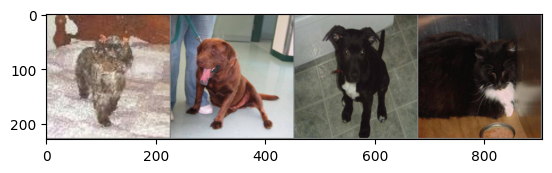

dog   dog   dog   cat  


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Define una función para mostrar una imagen
def imshow(img):
    # Desnormaliza la imagen
    img = img / 2 + 0.5
    # Convierte de Tensor a NumPy
    npimg = img.numpy()
    # Cambia el orden de los ejes para que sea compatible con matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Muestra la imagen
    plt.show()

# Diccionario de clases
classes = {0: 'cat', 1: 'dog'}

# Obtiene algunas imágenes de entrenamiento aleatorias
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Imprime las etiquetas
batch_size = len(images)
# Muestra las imágenes
imshow(torchvision.utils.make_grid(images))

# Imprime las etiquetas
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Definición de la red neuronal
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Definición de la primera capa convolucional: 3 canales de entrada, 6 filtros, tamaño del kernel 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Capa de agrupación máxima: tamaño de la ventana 2x2, paso 2
        self.pool = nn.MaxPool2d(2, 2)
        # Definición de la segunda capa convolucional: 6 canales de entrada (salida de la primera capa), 16 filtros, tamaño del kernel 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # Ajuste el tamaño de entrada
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
#define cómo se procesa la entrada a través de las distintas capas de la red neuronal
    def forward(self, x):
        # Operación convolucional seguida de la función de activación ReLU y agrupación máxima
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Aplanar la salida de las capas convolucionales para la entrada a las capas lineales
        x = torch.flatten(x, 1)  # Aplanar todas las dimensiones excepto el lote
        # Operaciones lineales seguidas de la función de activación ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Última capa lineal sin función de activación ya que se utilizará la función de pérdida CrossEntropyLoss
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
net = Net()



In [20]:
import torch.optim as optim #Importa el módulo de optimización de PyTorch 
# Definir la función de pérdida (CrossEntropyLoss para clasificación)
criterion = nn.CrossEntropyLoss() #Calcula la diferencia entre las predicciones del modelo y las etiquetas verdaderas
# Definir el optimizador (SGD con impulso)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #optimizador que actualizará los pesos del modelo durante el entrenamiento.


In [21]:
#Asigna automáticamente el dispositivo de cálculo adecuado (GPU si está disponible, de lo contrario, CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
for epoch in range(2):   # Itera sobre el número de épocas (en este caso, 2)

    running_loss = 0.0 # Inicializa la pérdida acumulada para esta época
    for i, data in enumerate(train_loader, 0): # Itera sobre los mini-lotes del conjunto de entrenamiento
         # Obtener las entradas; los datos son una lista de [entradas, etiquetas]
        inputs, labels = data[0].to(device), data[1].to(device)   # Mueve los datos al dispositivo de cálculo (GPU o CPU)
        
        # Reiniciar los gradientes de los parámetros
        optimizer.zero_grad()

        # Hacer la propagación hacia adelante + hacia atrás + optimizar
        outputs = net(inputs)  # Realiza la propagación hacia adelante para obtener las predicciones del modelo
        loss = criterion(outputs, labels) # Calcula la pérdida entre las predicciones y las etiquetas reales
        loss.backward() # Realiza la propagación hacia atrás para calcular los gradientes
        optimizer.step() # Actualiza los parámetros del modelo utilizando el optimizador

        # Imprimir estadísticas
        running_loss += loss.item() # Acumula la pérdida del mini-lote actual
        if i % 2000 == 1999:    # imprimir cada 2000 mini-lotes
            print(f'[{epoch + 1}, {i + 1:5d}] pérdida: {running_loss / 2000:.3f}')# Imprime la pérdida promedio del mini-lote
            running_loss = 0.0 # Reinicia la pérdida acumulada para el siguiente conjunto de mini-lotes

print('Entrenamiento terminado') # Imprime un mensaje cuando el entrenamiento ha finalizado



[1,  2000] pérdida: 0.739
[1,  4000] pérdida: 0.665
[2,  2000] pérdida: 0.610
[2,  4000] pérdida: 0.568
Entrenamiento terminado


In [24]:
# Define la ruta del archivo donde deseas guardar los pesos del modelo
PATH = './cifar_net_cat_dog_sprint2.pth'

# Guarda los pesos del modelo en el archivo
torch.save(net.state_dict(), PATH)


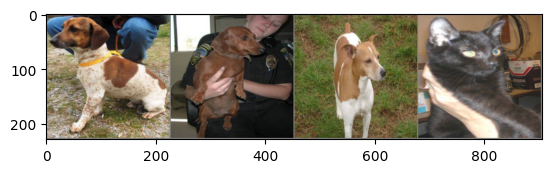

GroundTruth:  dog   dog   dog   cat  


In [25]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))
# Obtener las etiquetas como una lista de Python
labels_list = labels.tolist()
# Mapear las etiquetas numéricas a las clases utilizando el índice
class_names = [classes[label] for label in labels_list]
print('GroundTruth: ', ' '.join(f'{class_names[j]:5s}' for j in range(batch_size)))



In [26]:
# Define la red neuronal
net = Net()

# Carga los pesos guardados del modelo
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [27]:
# Obtener las predicciones de la red neuronal para las imágenes de prueba
outputs = net(images)


In [28]:
# Obtener el índice de la clase con la energía más alta
_, predicted = torch.max(outputs, 1)

# Convertir predicted a una lista de Python
predicted_list = predicted.tolist()

# Mapear los índices predichos a las clases utilizando las etiquetas
predicted_classes = [classes[index] for index in predicted_list]

# Imprimir las predicciones
print('Predicted: ', ' '.join(f'{predicted_classes[j]:5s}' for j in range(4)))


Predicted:  dog   dog   dog   dog  


In [29]:
correct = 0
total = 0
# Como no estamos entrenando, no necesitamos calcular los gradientes para nuestras salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Calcular las salidas pasando las imágenes a través de la red
        outputs = net(images)
        # La clase con la energía más alta es lo que elegimos como predicción
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Precisión de la red en las 5010 imágenes de prueba: {100 * correct // total} %')


Precisión de la red en las 5010 imágenes de prueba: 71 %


In [30]:
# Obtener las clases del diccionario classes
class_names = list(classes.values())
# Inicializar el diccionario correct_pred con las clases como claves y valores 0
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# Nuevamente, no necesitamos gradientes
with torch.no_grad():
    for data in test_loader: # Iterar sobre el conjunto de datos de prueba
        images, labels = data # Obtener las imágenes y etiquetas del batch de datos
        outputs = net(images) # Pasar las imágenes a través de la red neuronal para obtener las predicciones
        _, predictions = torch.max(outputs, 1)  # Obtener las predicciones finales tomando el índice de la clase con la energía más alta
        # Recolectar las predicciones correctas para cada clase
        for label, prediction in zip(labels, predictions):
            # Convertir label y prediction a valores numéricos
            label_value = label.item()
            prediction_value = prediction.item()

            # Usar los valores numéricos para acceder a los elementos en los diccionarios
            if label_value == prediction_value:
                correct_pred[class_names[label_value]] += 1
            total_pred[class_names[label_value]] += 1

# Imprimir precisión para cada clase
for classname, correct_count in correct_pred.items():
    total_count = total_pred[classname]
    accuracy = 100 * correct_count / total_count if total_count > 0 else 0
    print(f'Precisión para la clase: {classname:5s} es {accuracy:.1f} %')


Precisión para la clase: cat   es 59.0 %
Precisión para la clase: dog   es 82.8 %


In [31]:
client.close()